In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_ins = pd.read_csv('data/insurance.csv')

df_ins.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df_ins.shape

(1338, 7)

In [4]:
listItem = []

for col in df_ins.columns:
    listItem.append([col, df_ins[col].dtype, df_ins[col].isna().sum(), round((df_ins[col].isna().sum()/len(df_ins[col]))*100, 2),
                    df_ins[col].nunique(), list(df_ins[col].drop_duplicates().values)])

df_ins_desc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
df_ins_desc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,age,int64,0,0.0,47,"[19, 18, 28, 33, 32, 31, 46, 37, 60, 25, 62, 2..."
1,sex,object,0,0.0,2,"[female, male]"
2,bmi,float64,0,0.0,548,"[27.9, 33.77, 33.0, 22.705, 28.88, 25.74, 33.4..."
3,children,int64,0,0.0,6,"[0, 1, 3, 2, 5, 4]"
4,smoker,object,0,0.0,2,"[yes, no]"
5,region,object,0,0.0,4,"[southwest, southeast, northwest, northeast]"
6,charges,float64,0,0.0,1337,"[16884.924, 1725.5523, 4449.462, 21984.47061, ..."


In [5]:
df_ins.drop_duplicates(inplace=True)

In [6]:
df_ins.dropna(inplace=True)

In [7]:
num_features = [feature for feature in df_ins.columns if ((df_ins[feature].dtypes != 'object'))]
df_ins[num_features].describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


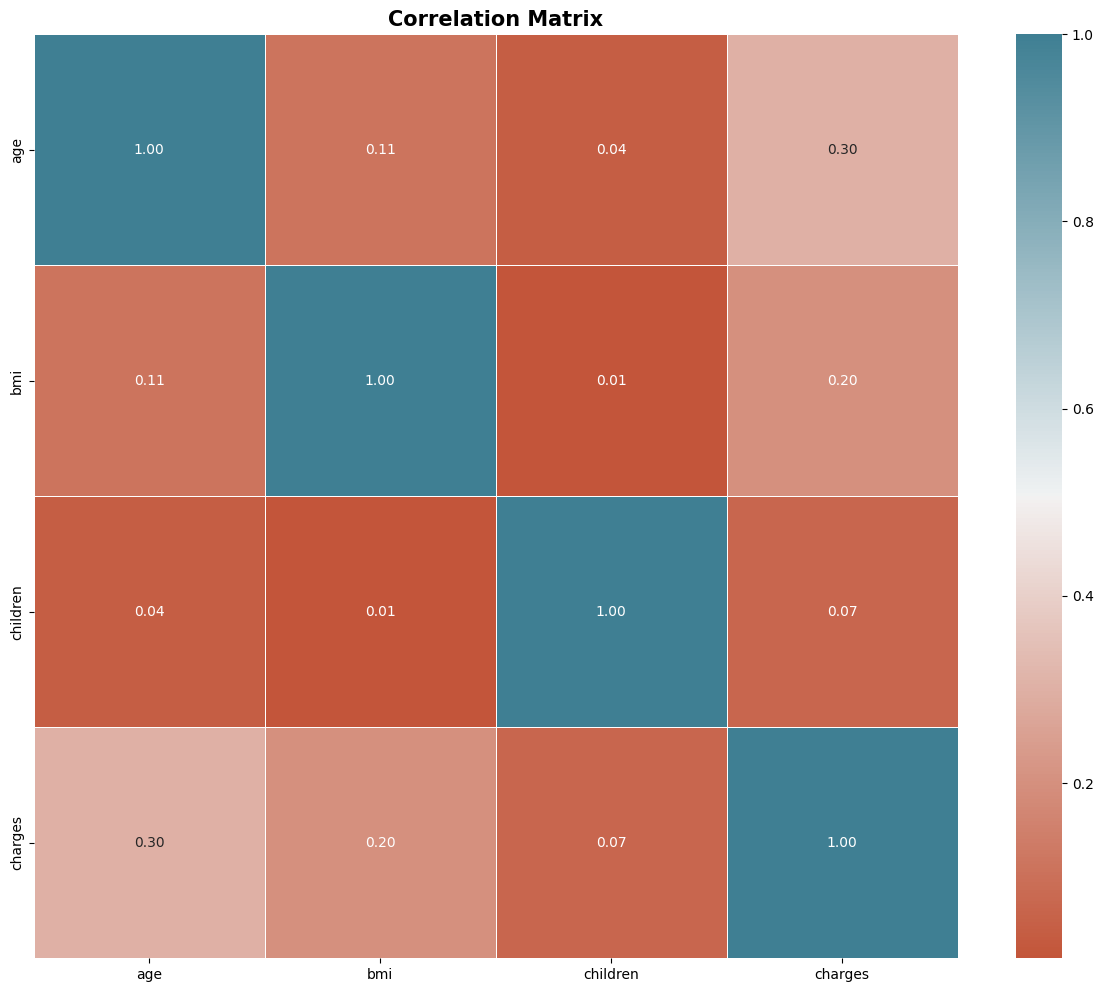

In [8]:
plt.figure(figsize=(15, 12))
palette=sns.diverging_palette(20, 220, n=256)
corr = df_ins[num_features].corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Correlation Matrix', size=15, weight='bold');

<Axes: >

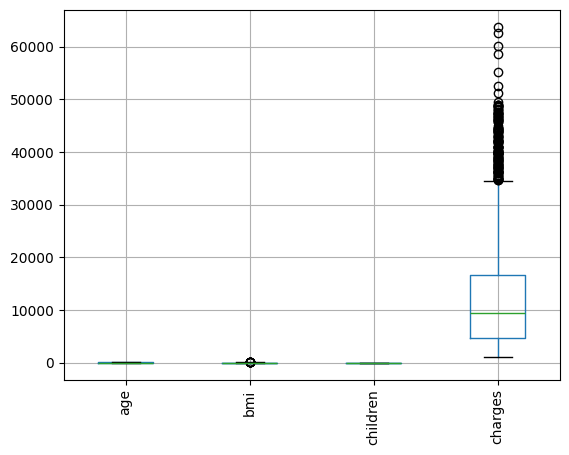

In [9]:
df_ins[num_features].boxplot(rot=90)

In [10]:
# Membuat fungsi untuk mengecek outliers
def find_anomalies(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR: {iqr}')

    limit_bawah = q1 - limit
    limit_atas = q3 + limit
    print(f'limit_bawah: {limit_bawah}')
    print(f'limit_atas: {limit_atas}')        

In [11]:
find_anomalies(df_ins['charges'])

IQR: 11911.37345
limit_bawah: -13120.716174999998
limit_atas: 34524.777625


In [12]:
df_ins['charges'].describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [13]:
df_ins[df_ins['charges'] > 34524.777625].count()['charges']

139

Text(0.5, 0, 'Range Selected Charges')

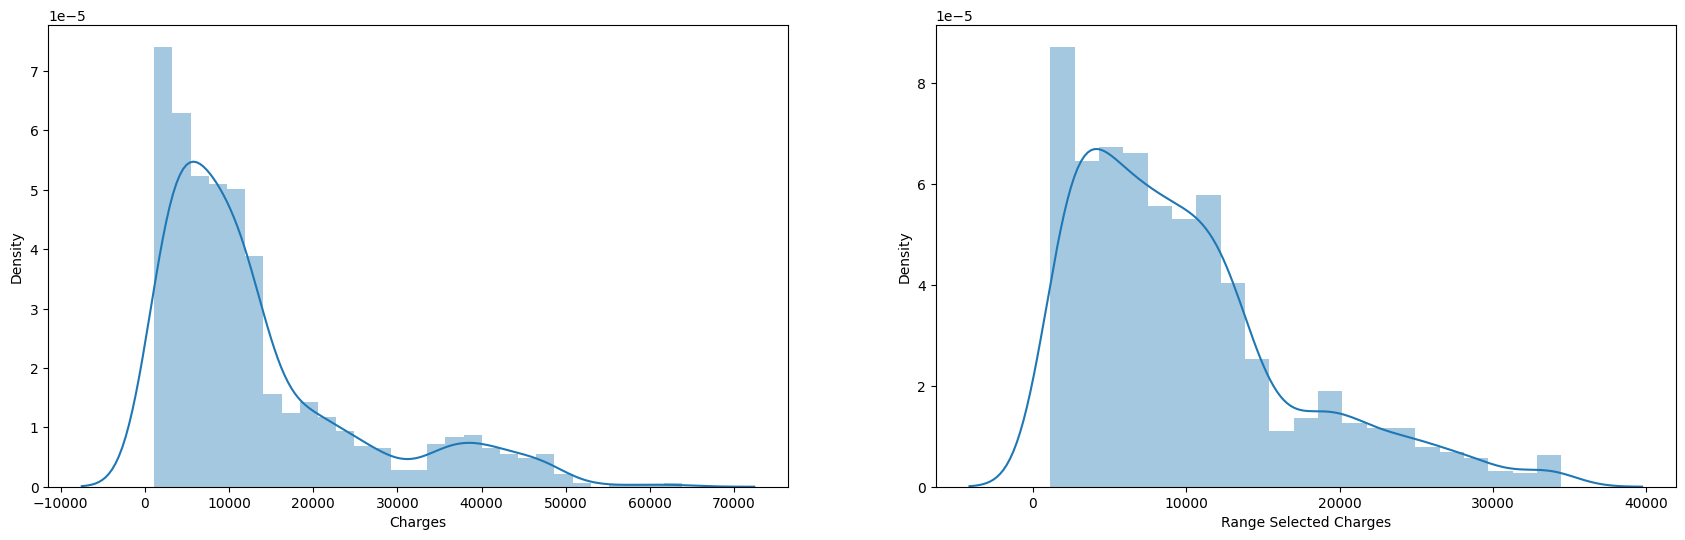

In [14]:
df_model = df_ins.copy()

df_model = df_model[(df_model['charges'] <= 34524.777625)]

fig, axes = plt.subplots(1,2, figsize=(21, 6))
sns.distplot(df_ins['charges'], ax=axes[0])
sns.distplot(df_model['charges'], ax=axes[1])
axes[0].set_xlabel('Charges')
axes[1].set_xlabel('Range Selected Charges')

In [15]:
df_ins = df_ins[(df_ins['charges'] <= 50000)]

In [16]:
df_ins.shape

(1330, 7)

In [17]:
df_ins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1330 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1330 non-null   int64  
 1   sex       1330 non-null   object 
 2   bmi       1330 non-null   float64
 3   children  1330 non-null   int64  
 4   smoker    1330 non-null   object 
 5   region    1330 non-null   object 
 6   charges   1330 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.1+ KB


In [18]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [19]:
transformer = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['sex', 'smoker', 'region'])
], remainder='passthrough')

In [20]:
X = df_ins.drop(['charges'], axis=1)
y = df_ins['charges']

In [21]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y,  
    test_size=0.2,
    random_state=1)

In [22]:
lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)
svm = SVR()

log_lr = TransformedTargetRegressor(lr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)
log_svm = TransformedTargetRegressor(svm, func=np.log, inverse_func=np.exp)

scaler = StandardScaler()

models = [log_lr, log_knn, log_dt, log_rf, log_xgb, log_svm]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())

[-9168.57528055 -7194.63620319 -8720.88346741 -8456.97300799
 -6536.95883613] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-4614.84441746 -3515.4663197  -4543.16090902 -4482.58501422
 -3367.14661531] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-0.27811198 -0.25315181 -0.25575075 -0.2887688  -0.25384916] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())
[-4765.66880673 -5002.99986945 -5975.60114961 -5638.86262931
 -5630.97671076] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
[-2868.94473755 -2732.45698425 -3318.43334197 -3261.05679552
 -3218.331689  ] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                    

In [23]:
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor', 'RandomForest Regressor', 'XGBoost Regressor', 'SVM Regressor'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape
})

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE
0,Linear Regression,-8015.605359,988.124298,-4104.640655,545.247409,-0.265927,0.014716
1,KNN Regressor,-5402.821833,447.586334,-3079.844710,234.135870,-0.253804,0.014373
2,DecisionTree Regressor,-6293.715575,519.197914,-2914.489500,321.070640,-0.327286,0.044376
3,RandomForest Regressor,-4573.342426,418.566594,-2157.280462,220.465333,-0.197219,0.011468
4,XGBoost Regressor,-5234.067478,366.572333,-2754.220554,220.017188,-0.250067,0.011314
5,SVM Regressor,-4922.694015,374.826620,-2328.754529,186.455103,-0.134604,0.006714


In [24]:
models = {
    'SVM': SVR(),
    'RandomForest': RandomForestRegressor(random_state=1)
}

score_rmse = []
score_mae = []
score_mape = []

for i in models:

    model = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', models[i])
        ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    score_mae.append(mean_absolute_error(y_test, y_pred))
    score_mape.append(mean_absolute_percentage_error(y_test, y_pred))

score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape}, index=models.keys())
score_before_tuning

,RMSE,MAE,MAPE
SVM,12520.018553,8102.804727,0.998504
RandomForest,4628.153204,2724.969399,0.357635


In [25]:
max_depth = list(np.arange(1, 11))

n_estimators = [100, 120, 140]

min_samples_split = list(np.arange(2, 20))

min_samples_leaf = list(np.arange(1, 20))

hyperparam_space_rf = {
    'model__max_depth': max_depth, 
    'model__n_estimators': n_estimators,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf
}

In [26]:
rf = RandomForestRegressor(random_state=1)

estimator_rf = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', rf)
        ])

crossval = KFold(n_splits=5, shuffle=True, random_state=1)

grid_rf = GridSearchCV(
    estimator_rf, 
    param_grid = hyperparam_space_rf,
    cv = crossval,
    scoring = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
    n_jobs = -1,
    refit = 'neg_root_mean_squared_error'
)

In [27]:
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('One '
                                                                         'Hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['sex',
                                                                          'smoker',
                                                                          'region'])])),
                                       ('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10, 11, 12, 13, 14, 15, 16,
                                                     17, 18, 19],
                         'model__min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                         'model__n_estimators': [100, 120, 140]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error'])

In [28]:
pd.DataFrame(grid_rf.cv_results_).sort_values(by=['rank_test_neg_root_mean_squared_error', 'rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_neg_mean_absolute_percentage_error,split1_test_neg_mean_absolute_percentage_error,split2_test_neg_mean_absolute_percentage_error,split3_test_neg_mean_absolute_percentage_error,split4_test_neg_mean_absolute_percentage_error,mean_test_neg_mean_absolute_percentage_error,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error
4430,0.489591,0.028980,0.015272,0.003241,5,7,2,140,"{'model__max_depth': 5, 'model__min_samples_le...",-4012.915671,...,174.3728,231,-0.306407,-0.303076,-0.265864,-0.295515,-0.344985,-0.303169,0.025335,4522
4433,0.484952,0.030067,0.015515,0.002996,5,7,3,140,"{'model__max_depth': 5, 'model__min_samples_le...",-4012.915671,...,174.3728,231,-0.306407,-0.303076,-0.265864,-0.295515,-0.344985,-0.303169,0.025335,4522
4436,0.490485,0.031718,0.015325,0.004246,5,7,4,140,"{'model__max_depth': 5, 'model__min_samples_le...",-4012.915671,...,174.3728,231,-0.306407,-0.303076,-0.265864,-0.295515,-0.344985,-0.303169,0.025335,4522
4439,0.487988,0.032675,0.013951,0.003163,5,7,5,140,"{'model__max_depth': 5, 'model__min_samples_le...",-4012.915671,...,174.3728,231,-0.306407,-0.303076,-0.265864,-0.295515,-0.344985,-0.303169,0.025335,4522
4442,0.492927,0.029910,0.015119,0.003465,5,7,6,140,"{'model__max_depth': 5, 'model__min_samples_le...",-4012.915671,...,174.3728,231,-0.306407,-0.303076,-0.265864,-0.295515,-0.344985,-0.303169,0.025335,4522


In [30]:
print('Random Forest')
print('Best_score:', grid_rf.best_score_)
print('Best_params:', grid_rf.best_params_)

Random Forest
Best_score: -4484.781710056362
Best_params: {'model__max_depth': 5, 'model__min_samples_leaf': 7, 'model__min_samples_split': 2, 'model__n_estimators': 140}


In [31]:
model = {'RandomForest': RandomForestRegressor(random_state=1)}

rf_tuning = grid_rf.best_estimator_

rf_tuning.fit(X_train, y_train)

y_pred_rf_tuning = rf_tuning.predict(X_test)

rmse_rf_tuning = np.sqrt(mean_squared_error(y_test, y_pred_rf_tuning))
mae_rf_tuning = mean_absolute_error(y_test, y_pred_rf_tuning)
mape_rf_tuning = mean_absolute_percentage_error(y_test, y_pred_rf_tuning)

score_after_tuning = pd.DataFrame({'RMSE': rmse_rf_tuning, 'MAE': mae_rf_tuning, 'MAPE': mape_rf_tuning}, index = model.keys())
score_after_tuning

,RMSE,MAE,MAPE
RandomForest,4070.613657,2317.30253,0.284075


In [32]:
pd.DataFrame(score_before_tuning.loc['RandomForest']).T

,RMSE,MAE,MAPE
RandomForest,4628.153204,2724.969399,0.357635


In [33]:
score_after_tuning

,RMSE,MAE,MAPE
RandomForest,4070.613657,2317.30253,0.284075


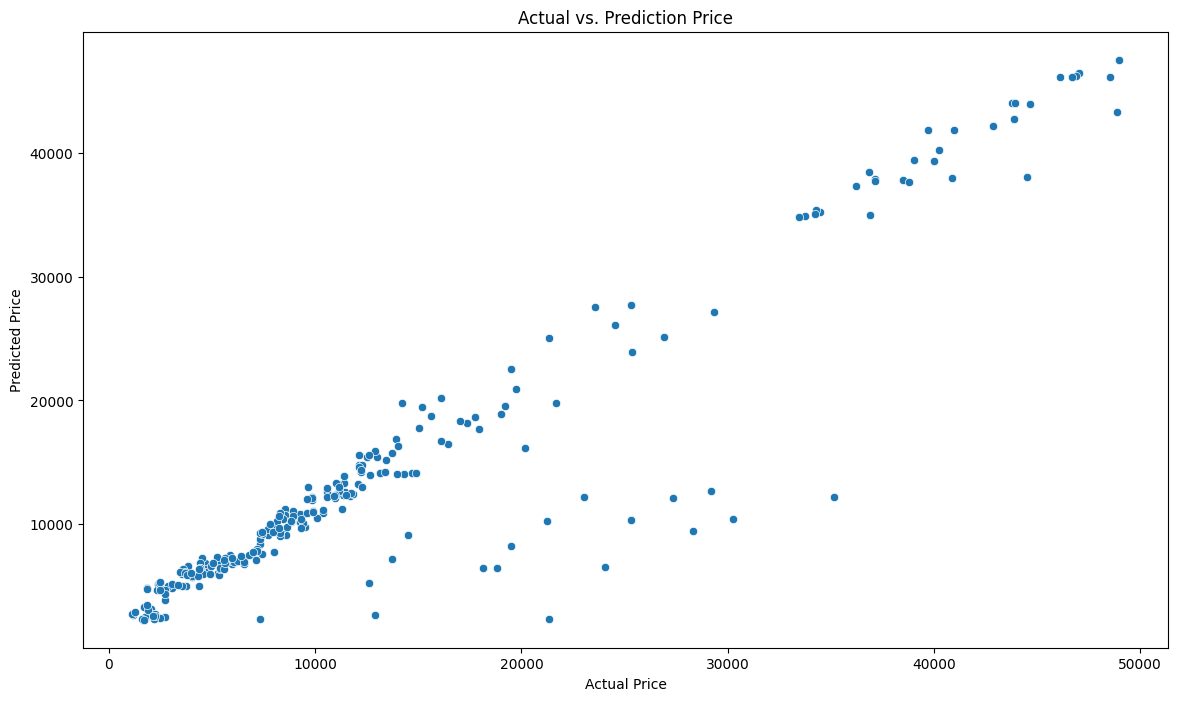

In [34]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_test, y=y_pred_rf_tuning).set(title='Actual vs. Prediction Price', 
                                               xlabel='Actual Price', 
                                               ylabel='Predicted Price')

In [36]:
resid = pd.DataFrame({'y-true': y_test, 'y_pred': y_pred, 'residual': y_test - y_pred})
resid.head()

,y-true,y_pred,residual
1264,10370.91255,12361.305693,-1990.393143
326,3561.88890,12282.183191,-8720.294291
935,12233.82800,13939.646197,-1705.818197
1025,2020.17700,3021.251743,-1001.074743
1160,7727.25320,11450.702389,-3723.449189


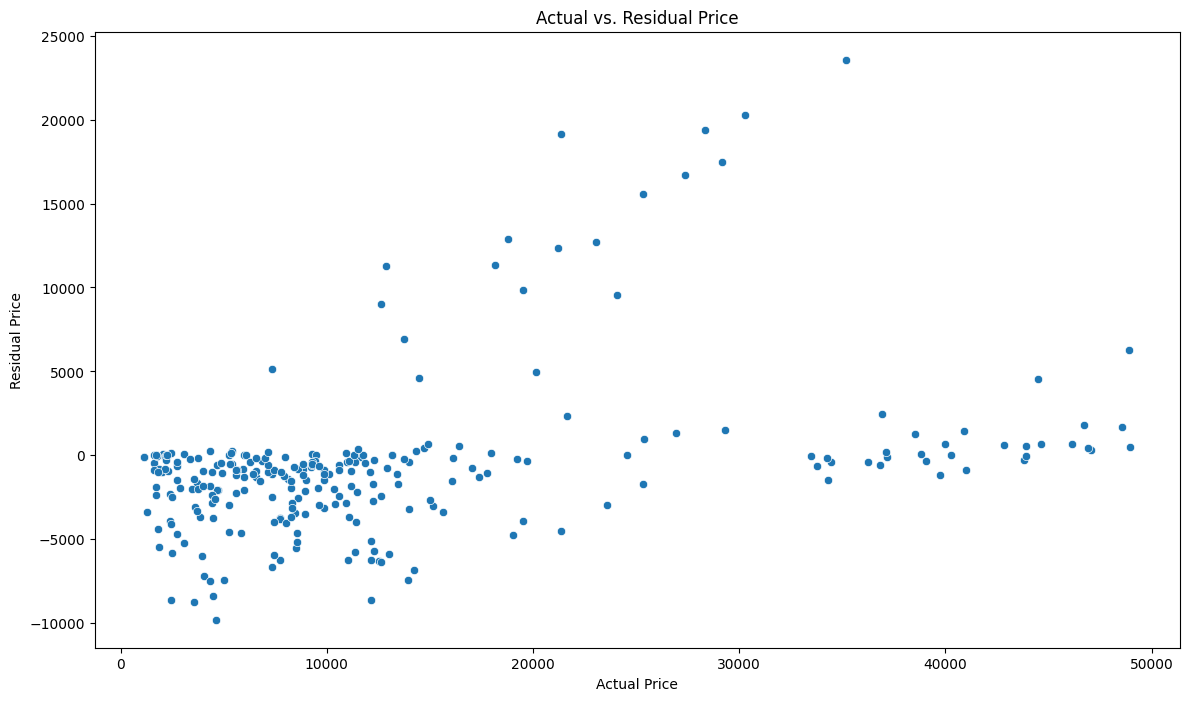

In [38]:
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=resid['y-true'], y=resid['residual']).set(title='Actual vs. Residual Price', 
                                               xlabel='Actual Price', 
                                               ylabel='Residual Price')

In [57]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score

# dbscan = DBSCAN(eps = 0.8, min_samples=20)
# clusters = dbscan.fit_predict(resid.drop(columns='y_pred'))

# clustering variation
number_of_cluster = range(2,11)
clusterings = [KMeans(n_clusters=k).fit(resid.drop(columns='y_pred')) for k in number_of_cluster]
centroids = [k.cluster_centers_ for k in clusterings]

# within sumsq
D_k = [cdist(resid.drop(columns='y_pred'), cent, 'euclidean') for cent in centroids] 
cIdx = [np.argmin(D, axis=1) for D in D_k] 
dist = [np.min(D, axis=1) for D in D_k] 
avgWithinSS = [sum(d)/resid.drop(columns='y_pred').shape[0] for d in dist] 

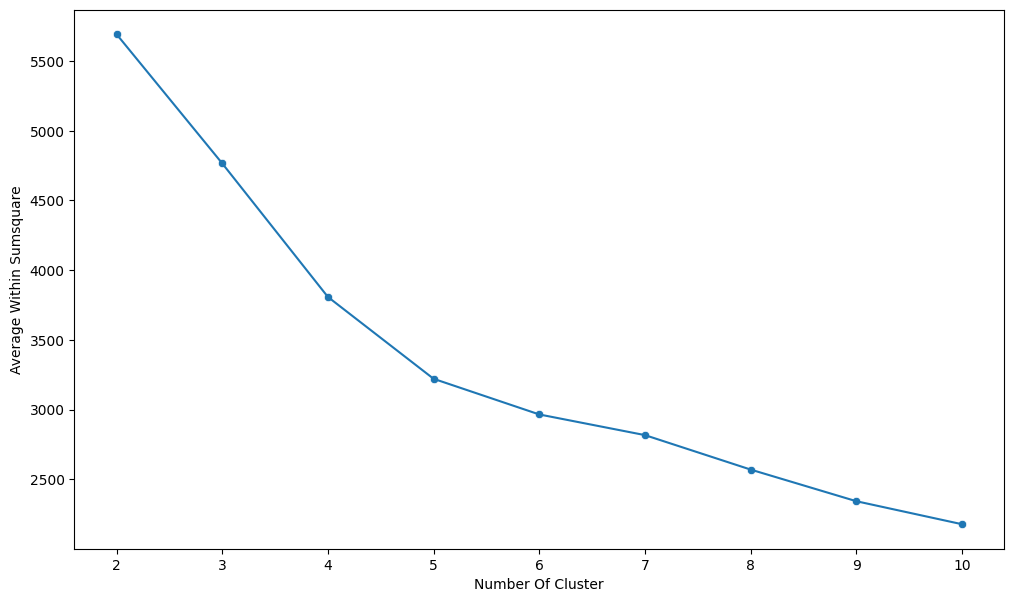

In [58]:
plt.figure(figsize=(12,7))
sns.lineplot(x=number_of_cluster, y=avgWithinSS)
sns.scatterplot(x=number_of_cluster, y=avgWithinSS)

plt.xticks(number_of_cluster)

plt.xlabel('Number Of Cluster')
plt.ylabel('Average Within Sumsquare')
plt.show()

In [60]:
# silhouette_score(resid.drop(columns='y_pred'), clusters)

silhouette_scores = []
number_of_cluster = range(2,11)

for i in number_of_cluster:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(resid.drop(columns='y_pred'))

  labels = kmeans.labels_
  silhouette_scores.append(silhouette_score(resid.drop(columns='y_pred'), labels, metric= 'euclidean'))

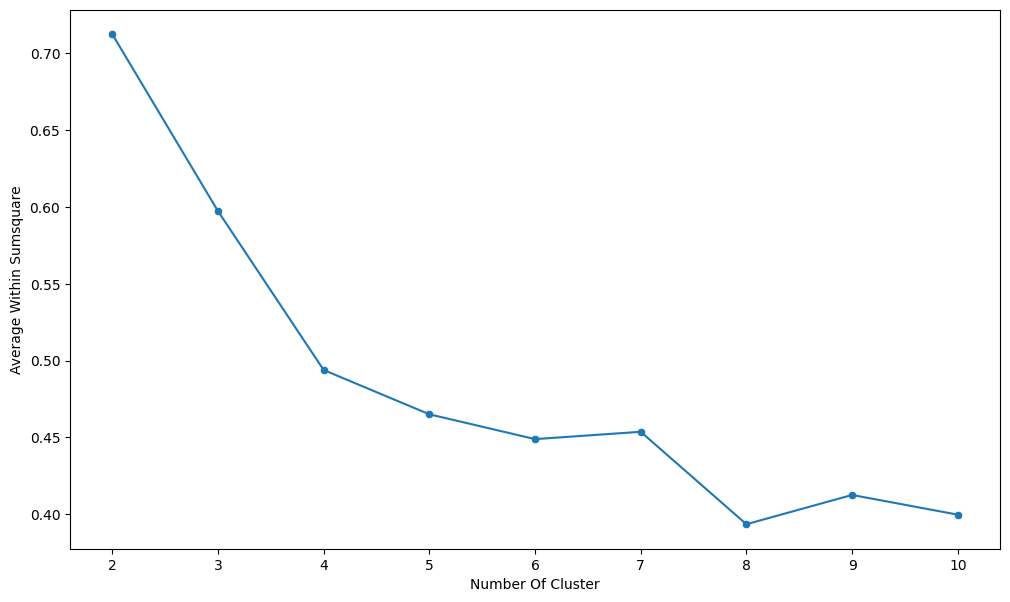

In [61]:
plt.figure(figsize=(12,7))

sns.lineplot(x=number_of_cluster, y=silhouette_scores)
sns.scatterplot(x=number_of_cluster, y=silhouette_scores)

plt.xticks(number_of_cluster)

plt.xlabel('Number Of Cluster')
plt.ylabel('Average Within Sumsquare')
plt.show()

In [62]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(resid.drop(columns='y_pred'))

KMeans(n_clusters=2)

In [65]:
resid['cluster'] = kmeans.labels_
resid

,y-true,y_pred,residual,cluster
1264,10370.91255,12361.305693,-1990.393143,0
326,3561.88890,12282.183191,-8720.294291,0
935,12233.82800,13939.646197,-1705.818197,0
1025,2020.17700,3021.251743,-1001.074743,0
1160,7727.25320,11450.702389,-3723.449189,0
...,...,...,...,...
976,7804.16050,8820.608349,-1016.447849,0
8,6406.41070,7533.668389,-1127.257689,0
242,35160.13457,11594.711213,23565.423357,1
284,9625.92000,10235.606610,-609.686610,0


Text(0, 0.5, 'Tinggi Badan Istri')

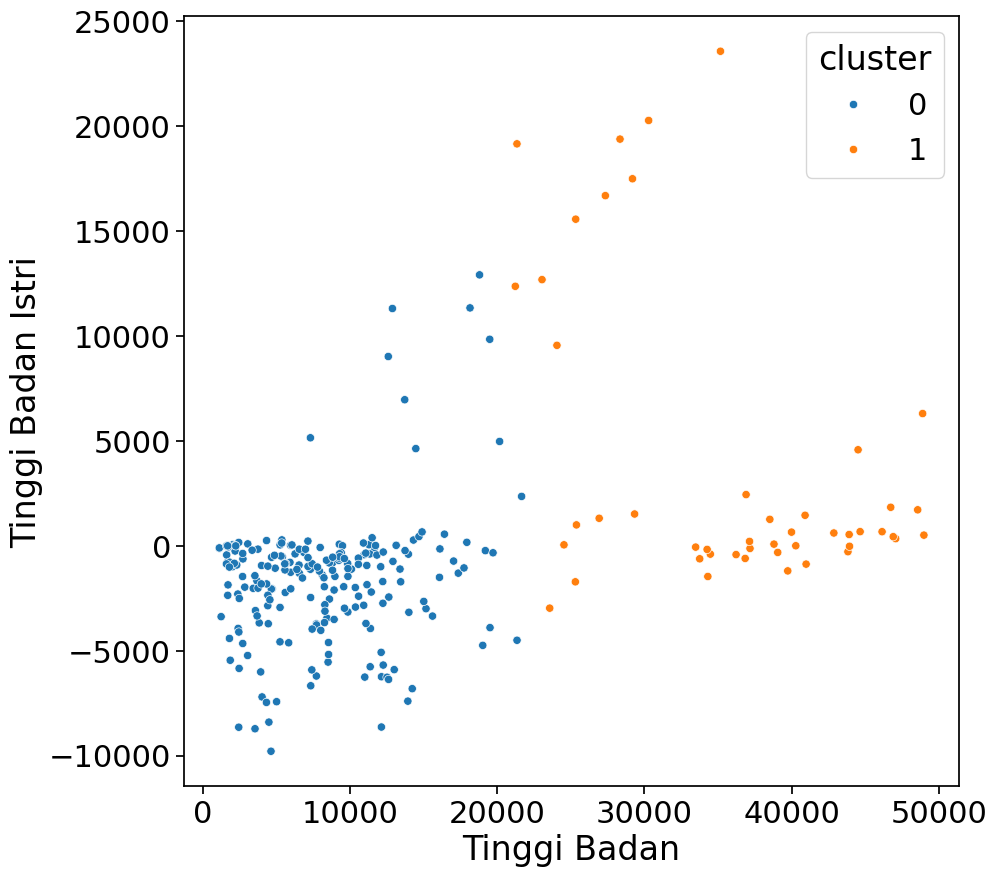

In [66]:
plt.figure(figsize = (10,10))
sns.set_context(context = 'notebook', font_scale=2)
sns.scatterplot(
    x = 'y-true', 
    y = 'residual', 
    hue = 'cluster',
    data = resid)

plt.xlabel('Tinggi Badan')
plt.ylabel('Tinggi Badan Istri')

In [35]:
import pickle

pickle.dump(rf_tuning, open('rf_model_charges.sav', 'wb'))